In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [291]:
df = pd.read_csv('D:/Data/apartment/cleaned_apartment.csv')

In [292]:
df.drop(['unit_name','link-href','apt_name','apt_id','grocery_store'],axis=1,inplace=True,errors='ignore')

In [293]:
df_clean = pd.get_dummies(df,columns=['region'])

In [294]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_clean['furnished'] = encoder.fit_transform(df.furnished)

# Modelling

In [295]:
X = df_clean.drop('annual_price',axis=1)
y = df_clean.annual_price

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Without hyperparameter

In [296]:
def evaluation(model):
    model.fit(X_train,y_train)
    print('R2 Score :', r2_score(y_test, model.predict(X_test)))
    print('MS Error :', mean_squared_error(y_test, model.predict(X_test)))
    print('RMS Error:', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    

In [297]:
# XGB
xgb = XGBRegressor()

In [298]:
evaluation(xgb)

R2 Score : 0.8019066233646699
MS Error : 2599730768913216.0
RMS Error: 50987555.039570354


In [299]:
# Catboost
catboost = CatBoostRegressor()
evaluation(catboost)

Learning rate set to 0.048562
0:	learn: 119206427.1648024	total: 2.38ms	remaining: 2.38s
1:	learn: 115229627.3351884	total: 4.61ms	remaining: 2.3s
2:	learn: 111312528.8823963	total: 6.99ms	remaining: 2.32s
3:	learn: 107756397.3517963	total: 8.74ms	remaining: 2.18s
4:	learn: 104559787.3629485	total: 10.9ms	remaining: 2.18s
5:	learn: 101114401.1780198	total: 13.3ms	remaining: 2.21s
6:	learn: 98237424.8208063	total: 15.5ms	remaining: 2.2s
7:	learn: 95380270.9610147	total: 17.2ms	remaining: 2.13s
8:	learn: 92656309.4856778	total: 19.3ms	remaining: 2.12s
9:	learn: 90229526.0214474	total: 21.5ms	remaining: 2.13s
10:	learn: 87738127.0156871	total: 23.7ms	remaining: 2.13s
11:	learn: 85425519.7071814	total: 26ms	remaining: 2.14s
12:	learn: 83083175.4025549	total: 29.9ms	remaining: 2.27s
13:	learn: 81076289.1512267	total: 32ms	remaining: 2.25s
14:	learn: 79206702.9530185	total: 34.3ms	remaining: 2.25s
15:	learn: 77244391.1131967	total: 36.6ms	remaining: 2.25s
16:	learn: 75563569.6122448	total: 3

In [300]:
# lgbm
lgb = LGBMRegressor()
evaluation(lgb)

R2 Score : 0.8368533500156263
MS Error : 2141098168013386.8
RMS Error: 46272001.98838804


Without set any parameter for each machine learning, Catboost model has the biggest r2_score and the lowest error

# HyperparameterTuning

## 1. XGB

In [313]:
params1 = {'learning_rate':[x for x in np.arange(0.05,0.5,0.05)],
          'n_estimators' :[j for j in range(80,100)],
          'max_depth':[a for a in range(1,8)],
          'min_child_weight':[b for b in range(1,9)],    
          'gamma': range(1, 9),
          "reg_alpha": [m for m in np.arange(0.1, 0.7,0.09)],
           'scale_pos_weight':[13.92,14]
         }
params2 = {
        'max_depth': (4, 6),
        'gamma': (0.0001, 0.005),
        'min_child_weight': (1, 2),
        'max_delta_step': (0, 1),
        'subsample': (0.2, 0.4),
        'colsample_bytree': (0.2, 0.4)
        }

In [314]:
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
skf = StratifiedKFold(3,shuffle=True,random_state=42)

In [315]:
gsc = GridSearchCV(xgb,params2,cv=skf.get_n_splits(X,y),n_jobs=-1,verbose=1,scoring='r2')
gsc.fit(X_train,y_train)

print(gsc.score(X_test,y_test))
print(gsc.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
0.849635026368854
{'colsample_bytree': 0.4, 'gamma': 0.0001, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.4}


In [316]:
rsc = RandomizedSearchCV(xgb,params1,cv=skf.get_n_splits(X,y),n_jobs=-1,verbose=1,scoring='r2',random_state=42)
rsc.fit(X_train,y_train)

print(rsc.score(X_test,y_test))
print(rsc.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.8667716248944901
{'scale_pos_weight': 13.92, 'reg_alpha': 0.5499999999999999, 'n_estimators': 80, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 8}


## 2. LightGBM

In [305]:
gparams = {'learning_rate':[0.4,0.57],
          'n_estimators' :[92],
          'max_depth':[5,7],
          'min_child_weight':[4,6],    
          'gamma': [8],
          "reg_alpha": [0.37,0.5]
           }

gparams1 = {'learning_rate':[i for i in np.arange(0.3,1,0.1)],
          'n_estimators' :[j for j in range(90,100)],
          'max_depth':[k for k in range(3,9)],
          'min_child_weight':[4,6],    
          'gamma': [8],
          "reg_alpha": [0.37,0.5]
           }

In [306]:
gsc1 = GridSearchCV(lgb,params2,cv=skf.get_n_splits(X,y),verbose=1,n_jobs=-1,scoring='r2')
gsc1.fit(X_train,y_train)

print(gsc1.score(X_test,y_test))
print(gsc1.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Warning] Unknown parameter: gamma
0.846999941068245
{'colsample_bytree': 0.4, 'gamma': 0.0001, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.2}


In [307]:
rsc1 = RandomizedSearchCV(lgb,gparams1,cv=3,verbose=1,n_jobs=-1,scoring='r2')
rsc1.fit(X_train,y_train)

print(rsc1.score(X_test,y_test))
print(rsc1.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Unknown parameter: gamma
0.8398734149828725
{'reg_alpha': 0.5, 'n_estimators': 95, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 8}


## 3.Catboost

In [330]:
cparam = {"learning_rate": np.linspace(0,0.2,5)}


In [331]:
rsc2 = RandomizedSearchCV(catboost,cparam,cv=skf.get_n_splits(X,y),n_jobs=-1,scoring='r2')
rsc2.fit(X_train,y_train)

print(rsc2.score(X_test,y_test))
print(rsc2.best_params_)

C:\Users\jalal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning:

The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.

C:\Users\jalal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jalal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  

0:	learn: 119076500.8846153	total: 2.35ms	remaining: 2.34s
1:	learn: 114979703.4886551	total: 3.94ms	remaining: 1.97s
2:	learn: 110955619.0648675	total: 5.42ms	remaining: 1.8s
3:	learn: 107299388.3218234	total: 6.46ms	remaining: 1.61s
4:	learn: 104018128.9404812	total: 7.73ms	remaining: 1.54s
5:	learn: 100495222.1597590	total: 9.05ms	remaining: 1.5s
6:	learn: 97571153.8355806	total: 10.3ms	remaining: 1.46s
7:	learn: 94664155.8871095	total: 11.2ms	remaining: 1.39s
8:	learn: 92019237.6099272	total: 12.4ms	remaining: 1.37s
9:	learn: 89523506.5956943	total: 13.8ms	remaining: 1.37s
10:	learn: 86901218.6433204	total: 15.2ms	remaining: 1.36s
11:	learn: 84561873.8745891	total: 16.5ms	remaining: 1.36s
12:	learn: 82370012.6018947	total: 17.9ms	remaining: 1.36s
13:	learn: 80344685.2936515	total: 19.2ms	remaining: 1.35s
14:	learn: 78386640.2895568	total: 20.6ms	remaining: 1.35s
15:	learn: 76516372.0970017	total: 22ms	remaining: 1.35s
16:	learn: 74895294.7029834	total: 23.5ms	remaining: 1.36s
17:	l

# Feature Importance

<AxesSubplot:>

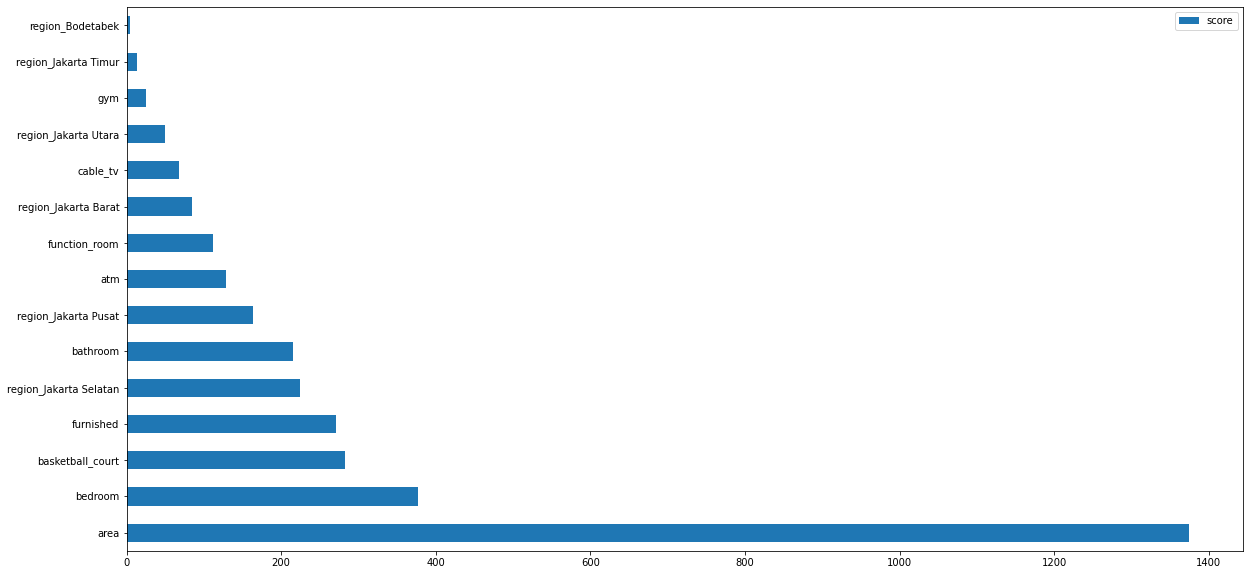

In [335]:
model = XGBRegressor(scale_pos_weight= 13.92, reg_alpha= 0.5499999999999999, n_estimators= 80, min_child_weight= 4, max_depth= 6, learning_rate= 0.05, gamma= 8)
model.fit(X_train,y_train)
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

# Summary

- We choose XGB Model
- Area is the most important thing for annual price